## eval_impact_of_tickets_associations

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
# Load data

tickets = pd.read_csv('../data/cleaned_data/Tickets.csv').dropna()
ignore_column_tickets = ['ITIN_ID', 'YEAR', 'QUARTER', 'ORIGIN_COUNTRY', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'ROUNDTRIP']
# tickets = tickets.drop(columns=ignore_column_tickets)
# # remove tickets that visit airports outside of the US
# tickets = tickets[(tickets['DEST_AIRPORT_IATA'].isin(airports['IATA_CODE'])) & (tickets['ORIGIN_AIRPORT_IATA'].isin(airports['IATA_CODE']))]
# tickets = tickets.assign(sorted_route = tickets.apply(lambda x : tuple(sorted([x['ORIGIN_AIRPORT_IATA'], x['DEST_AIRPORT_IATA']])), axis=1))
# tickets = tickets.drop(['ORIGIN_AIRPORT_IATA', 'DEST_AIRPORT_IATA'], axis=1)

tickets = tickets.assign(
        sorted_route=tickets.apply(
            lambda x: tuple(
                sorted([x["ORIGIN_AIRPORT_IATA_CODE"], x["DEST_AIRPORT_IATA_CODE"]])
            ),
            axis=1,
        )
    )

# Checking how many tickets associated with each round-trip routes

It is critical to check the number of tickets associated with the round trip routes because we calculate average ticket price based on the ticket associated with each round trip route. Specially for round-trip routes associated with only a single ticket, the analysis would be highly biased if we only rely on a single ticket for that round-trip route

In [202]:
roundtrip_route_distribution = tickets.groupby('sorted_route')['ITIN_ID'].count().value_counts(normalize=True)
roundtrip_route_distributions_more_than_10 = roundtrip_route_distribution[roundtrip_route_distribution.index > 9].sum()
roundtrip_route_distribution = roundtrip_route_distribution.reset_index().loc[:8]
roundtrip_route_distribution.loc[9] = {'index' : '10 or more', 'ITIN_ID' : roundtrip_route_distributions_more_than_10}
roundtrip_route_distribution.columns = ['# of tickets on roundtrip route', 'Percetange of roundtrip routes']

roundtrip_route_distribution['# of tickets on roundtrip route'] = pd.Series(['1 ticket', '2 tickets', '3 tickets', '4 tickets', '5 tickets', '6 tickets', '7 tickets', '8 tickets', '9 tickets', '10 or more'])

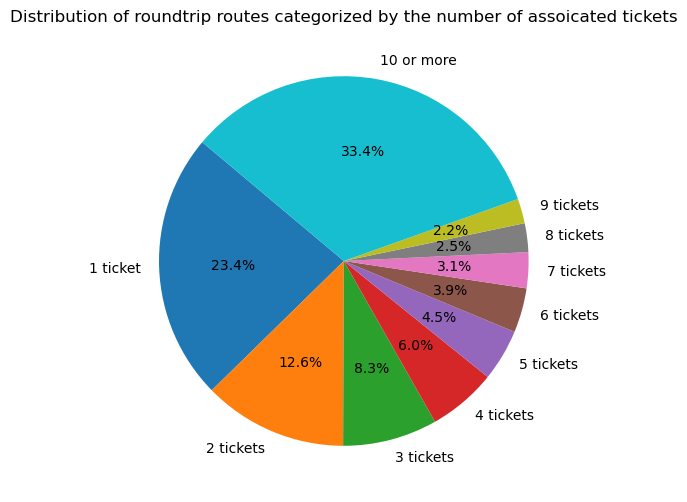

In [240]:
plt.figure(figsize=(10, 6))
plt.pie(roundtrip_route_distribution['Percetange of roundtrip routes'], labels=roundtrip_route_distribution['# of tickets on roundtrip route'], autopct='%1.1f%%', startangle=140)

plt.title('Distribution of roundtrip routes categorized by the number of assoicated tickets');

# Investiage the round trip route only associated with less than 3 tickets
- we hypothesis that unexpected distribution of single ticket association might be due to certain factors
- potential candidates
    - OP_CARRIER
    - ORIGIN_AIRPORT_IATA_CODE
    - ORIGIN_STATE_ABR
    - DEST_AIRPORT_IATA_CODE
    - ONE_PASSENGERS_FARE

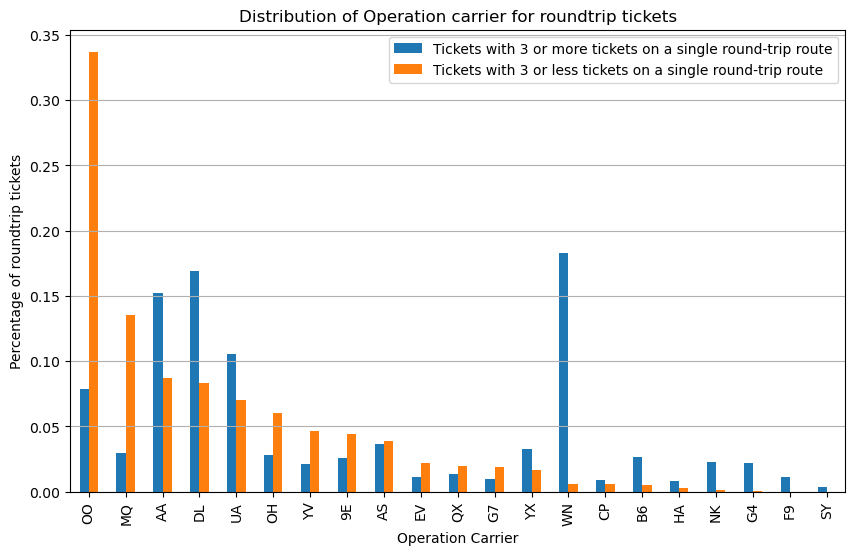

In [252]:
x = tickets.groupby('sorted_route').filter(lambda x: len(x) > 3)['OP_CARRIER'].value_counts(True)
y = tickets.groupby('sorted_route').filter(lambda x: len(x) <= 3)['OP_CARRIER'].value_counts(True)
df = pd.DataFrame({'x': x, 'y': y}).sort_values('y', ascending=False)
ax = df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Operation carrier for roundtrip tickets')
plt.xlabel('Operation Carrier')
plt.ylabel('Percentage of roundtrip tickets')
plt.legend(['Tickets with 3 or more tickets on a single round-trip route', 'Tickets with 3 or less tickets on a single round-trip route'])
plt.grid(axis='y')

### Conducting Hypothesis Testing 

We hypothesis that the less ticket association(roundtrips associated with less than 3 tickets) happen due to the Operation Carrier. And we will conduct hypothesis testing on this problem.

Null Hypothesis: There is no direct correlation between the Operation carrier and less ticket assoication. Thus, any distributions is due to random chance
Alternative Hypothesis: There is some corrleations happening between the Operation carrier and ticket assoications

test stiatistic: The Total variation distance between the distribution of Operation carriers of tickets with less than 3 associations and the distribution of Operation carriers of tickets with more than 3 association

In [255]:
# finding sample statistic
def tvd(series1, series2):
    ser_diff = series1.combine(series2, lambda x, y: y  if pd.isnull(x) else x if pd.isnull(y) else x - y)
    return 0.5 * np.sum(np.abs(ser_diff))

In [288]:
observed_tvd = tvd(tickets.groupby('sorted_route').filter(lambda x: len(x) > 3)['OP_CARRIER'].value_counts(True), tickets.groupby('sorted_route').filter(lambda x: len(x) <= 3)['OP_CARRIER'].value_counts(True))

In [311]:
sim_times = 1000

sim_tvd = []
for i in range(sim_times):
    perm_tickets = tickets.assign(OP_CARRIER = np.random.permutation(tickets['OP_CARRIER']))
    route_less_association = perm_tickets.groupby('sorted_route')['ITIN_ID'].count()
    route_less_association = pd.Series(route_less_association[route_less_association <= 3].index)

    dis1 = perm_tickets[perm_tickets['sorted_route'].isin(route_less_association)]['OP_CARRIER'].value_counts(True)
    dis2 = perm_tickets[~perm_tickets['sorted_route'].isin(route_less_association)]['OP_CARRIER'].value_counts(True)


    sim_tvd.append(tvd(dis1, dis2))

Text(0.5, 1.0, 'Distribution of simulated TVD')

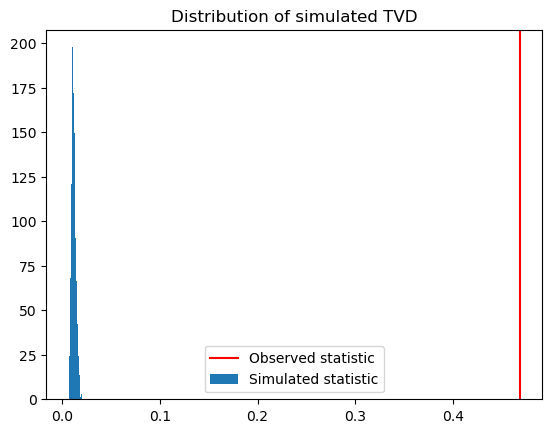

In [328]:
plt.hist(sim_tvd, density=True, bins=20)
plt.axvline(observed_tvd, color='r')

plt.legend(['Observed statistic', 'Simulated statistic'])
plt.title('Distribution of simulated TVD')

# plt.grid(axis='both')

p-value of 0 which reject the null hypothesis

# result

There might be an association between the operation carrier and associated ticket